In [1]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage import measure
from skimage.transform import resize
import plotly.graph_objects as go
import time
import os
import gc
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [ ]:
Molecule = {
    "name": "Acyclovir",
    "element": [
        8,
        8,
        8,
        7,
        7,
        7,
        7,
        7,
        6,
        6,
        6,
        6,
        6,
        6,
        6,
        6,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ],
    "x": [
        -2.4641,
        3.8291,
        -4.6589,
        -0.3931,
        1.2666,
        0.6329,
        2.8592,
        1.9621,
        0.6358,
        -1.6871,
        1.6358,
        0.0344,
        2.8832,
        -3.7632,
        1.7644,
        -4.537,
        -1.5384,
        -2.167,
        -0.5932,
        -3.685,
        -4.276,
        3.6954,
        -5.5379,
        -4.005,
        1.2357,
        2.8382,
        -5.1573
    ],
    "y": [
        0.0296,
        1.0019,
        0.0593,
        0.95,
        2.2424,
        -1.2357,
        -1.0433,
        -3.1485,
        0.1088,
        0.5894,
        0.9298,
        2.2226,
        0.3504,
        -0.3384,
        -1.7933,
        -0.9251,
        -0.1385,
        1.4907,
        3.0907,
        -1.0764,
        0.5553,
        -1.5553,
        -1.2341,
        -1.7824,
        -3.7702,
        -3.5688,
        -0.3468
    ],
    "z": [
        -0.1437,
        0.9368,
        1.5967,
        -0.6713,
        0.088,
        -0.5021,
        0.3623,
        -0.1899,
        -0.3656,
        -1.1987,
        0.0965,
        -0.3814,
        0.5119,
        -0.5877,
        -0.1289,
        0.577,
        -2.0036,
        -1.5952,
        -0.5312,
        -1.3934,
        -0.9616,
        0.6282,
        0.2622,
        1.0012,
        -0.528,
        0.1004,
        2.3263
    ],
    "b_s": [
        1,
        1,
        2,
        3,
        3,
        4,
        4,
        4,
        5,
        5,
        6,
        6,
        7,
        7,
        7,
        8,
        8,
        8,
        9,
        10,
        10,
        11,
        12,
        14,
        14,
        14,
        16,
        16
    ],
    "b_e": [
        10,
        14,
        13,
        16,
        27,
        9,
        10,
        12,
        11,
        12,
        9,
        15,
        13,
        15,
        22,
        15,
        25,
        26,
        11,
        17,
        18,
        13,
        19,
        16,
        20,
        21,
        23,
        24
    ],
    "b_o": [
        1,
        1,
        2,
        1,
        1,
        1,
        1,
        1,
        1,
        2,
        1,
        2,
        1,
        1,
        1,
        1,
        1,
        1,
        2,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1
    ],
    "i": [
        7.3704,
        4.269,
        8.9702,
        6.0812,
        6.0812,
        4.269,
        3.403,
        2.5369,
        5.135,
        6.3919,
        5.135,
        6.6648,
        4.269,
        7.6811,
        3.403,
        8.6596,
        6.3713,
        5.7781,
        7.2848,
        7.6605,
        7.0672,
        2.866,
        8.6801,
        9.2734,
        2.5369,
        2,
        9.5769
    ],
    "j": [
        0.8632,
        -3.0983,
        2.9704,
        -0.2936,
        -1.903,
        -0.0983,
        -1.5983,
        -0.0983,
        -0.5983,
        0.657,
        -1.5983,
        -1.0983,
        -2.0983,
        1.8137,
        -0.5983,
        2.0199,
        1.2766,
        0.7443,
        -1.0983,
        2.4334,
        1.901,
        -1.9083,
        1.4003,
        1.9326,
        0.5217,
        -0.4083,
        3.0983
    ]
}

In [ ]:
Config = {
    "dx": 0.3,
    "N": 150,
    "L": 45,
    "Z": 0,
    "lr": 0.1,
    "ball": True,
    "fast": False,
    "lumo": 0,
    "ion_ene": [0, 13.59844, 24.58738, 
                5.39171, 9.32269, 8.29803, 11.26030, 14.53414, 13.61806, 17.42282, 21.5646,
                5.13908, 7.64624, 5.98577, 8.15169, 10.48669, 10.36001, 12.96764, 15.75962]
}
Train = {
    "N": None,
    "density_i": [],
    "density_o": [],
    "density_f": [],
    "difference": []
}
Result = {
    "orbits": None,
    "orbits_e": None,
    "density": None,
    "partition": None,
    "energy": None,
    "charge": None,
    "dipole": None,
    "shape": None,
    "space": None,
    "grid": None,
    "Q_atom": None,
    "N_atom": None,
    "loss": None
}

In [ ]:
# Visualize Function
def visualize(func, thres=1e-6, fig_sz=8, fig_name=None):
    verts, faces, _, _ = measure.marching_cubes(func, thres, spacing=(0.1, 0.1, 0.1))
    intensity = np.linalg.norm(verts, axis=1)

    fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2],
                                    i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                    intensity=intensity,
                                    colorscale='Agsunset',
                                    opacity=1.0)])
    fig.update_layout(scene=dict(xaxis=dict(visible=False),
                                 yaxis=dict(visible=False),
                                 zaxis=dict(visible=False),
                                 bgcolor='rgb(0, 0, 0)'),
                      margin=dict(l=0, r=0, b=0, t=0),
                      width=fig_sz*79,
                      height=fig_sz*79)
    fig.update_traces(showscale=False)
    if fig_name is not None:
        fig.write_image(fig_name)
    fig.show()

In [ ]:
def plotmolecule(molecule, charge, fig_sz=8, show_charge=True, glow=True, fig_name=None):
    # Plot
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(fig_sz,fig_sz))
    ax = fig.add_subplot(111, facecolor=(0,0,0))
    ax.set_axis_off()
    ax.add_artist(ax.patch)
    ax.patch.set_zorder(-1)
    L = max(max(molecule["i"])-min(molecule["i"]), max(molecule["j"])-min(molecule["j"]))
    
    # Atom
    a_rad = [0, 120, 140,
              182, 153, 192, 170, 155, 152, 147, 154]
    a_name = ["", "H", "He",
              "Li", "Be", "B", "C", "N", "O", "F", "Ne"]
    fnt_sz = 4 * fig_sz / L
    for i in range(len(molecule["element"])):
        e = molecule["element"][i]
        x = molecule["i"][i]
        y = molecule["j"][i]
        r = a_rad[e] * 0.0015
        c = charge[i]
        color = cm.bwr_r(np.clip(c/2+0.5, 0, 0.999))
        name = a_name[e]
        if show_charge == True:
            name += '\n' + str(round(c, 2))
        circle = plt.Circle((x,y), r, color=color, zorder=1)
        ax.add_artist(circle)
        if glow == True:
            for rg in range(1,11):
                circle = plt.Circle((x,y), r+abs(c)*rg/50, color=color, alpha=0.08, zorder=1)
                ax.add_artist(circle)
        plt.text(x, y, name, color='black', fontsize=fnt_sz, ha='center', va='center', zorder=2)
    
    # Bond
    for i in range(len(molecule["b_o"])):
        sx = molecule["i"][molecule["b_s"][i]-1]
        sy = molecule["j"][molecule["b_s"][i]-1]
        ex = molecule["i"][molecule["b_e"][i]-1]
        ey = molecule["j"][molecule["b_e"][i]-1]
        bo = molecule["b_o"][i]
        for j in range(bo):
            ds = -0.1 + (j+1)*0.2/(bo+1)
            dx = ds * (ey-sy) / np.linalg.norm([ex-sx, ey-sy])
            dy = ds * (sx-ex) / np.linalg.norm([ex-sx, ey-sy])
            plt.plot([sx+dx, ex+dx], [sy+dy, ey+dy], color='white', linewidth=2.5, zorder=0)
    
    ax.set_xlim(sum(molecule["i"])/len(molecule["i"])-L/2-1, sum(molecule["i"])/len(molecule["i"])+L/2+1)
    ax.set_ylim(sum(molecule["j"])/len(molecule["j"])-L/2-1, sum(molecule["j"])/len(molecule["j"])+L/2+1)
    
    # Show
    if fig_name is not None:
        plt.savefig(fig_name)
    plt.show()

In [ ]:
def plotbackbone(molecule, N, L, wid=0.2):
    Q0 = np.zeros((N, N, N, 3))
    Q0[:,:,:,0] = np.linspace(-L/2, L/2, N)[:, np.newaxis, np.newaxis]
    Q0[:,:,:,1] = np.linspace(-L/2, L/2, N)[np.newaxis, :, np.newaxis]
    Q0[:,:,:,2] = np.linspace(-L/2, L/2, N)[np.newaxis, np.newaxis, :]
    Q = Q0.reshape((N**3, 3))
    
    ND = np.full(N**3, False)
    for i in range(len(molecule["b_o"])):
        s = molecule["b_s"][i] - 1
        e = molecule["b_e"][i] - 1
        a = np.array([molecule["x"][s], molecule["y"][s], molecule["z"][s]]) * 1.889726125
        b = np.array([molecule["x"][e], molecule["y"][e], molecule["z"][e]]) * 1.889726125
        pa = np.broadcast_to(a, Q.shape)
        pb = np.broadcast_to(b, Q.shape)
        dis = np.linalg.norm(np.cross((pb-pa), Q-pa), axis=1) / np.linalg.norm(b-a)
        pro = np.sum((pb-pa)*(Q-pa), axis=1) / np.linalg.norm(b-a) ** 2
        ND += (dis < wid) * (pro >= 0) * (pro <= 1)
    for i in range(len(molecule["element"])):
        a = np.array([molecule["x"][i], molecule["y"][i], molecule["z"][i]]) * 1.889726125
        pa = np.broadcast_to(a, Q.shape)
        dis = np.linalg.norm(pa-Q, axis=1)
        ND += (dis < wid)
    return ND

In [ ]:
# Density Functional Theory
def calculate(config, molecule, train, result):
    t_start = time.time()
    gc.collect()
    torch.cuda.empty_cache()
    
    # Config
    Atom = []
    Qm = np.zeros((3,3))
    for i in range(len(molecule["element"])):
        Atom.append([molecule["element"][i], np.array([molecule["x"][i], molecule["y"][i], molecule["z"][i]]) * 1.889726125])
        Qm[:,0] = np.maximum(Qm[:,0], Atom[i][1])
        Qm[:,1] = np.minimum(Qm[:,1], Atom[i][1])
        Qm[:,2] += Atom[i][0] * Atom[i][1]
    Qc = Qm[:,2] / sum(molecule["element"])
    Qm -= Qc
    for a in Atom:
        a[1] -= Qc
    dx = config["dx"]
    N = [config["N"]] * 3
    L = [config["L"]] * 3
    Z = config["Z"] + sum(molecule["element"])
    lr = config["lr"]
    ball = config["ball"]
    fast = config["fast"]
    lumo = config["lumo"]
    ion_ene = config["ion_ene"]
    
    # Grid Space
    Q0 = np.zeros((3, N[0], N[1], N[2]))
    Q0[0,:,:,:] = np.linspace(-L[0]/2, L[0]/2, N[0])[:, np.newaxis, np.newaxis]
    Q0[1,:,:,:] = np.linspace(-L[1]/2, L[1]/2, N[1])[np.newaxis, :, np.newaxis]
    Q0[2,:,:,:] = np.linspace(-L[2]/2, L[2]/2, N[2])[np.newaxis, np.newaxis, :]
    FP = np.full(N, True)
    if ball is True:
        FP = np.linalg.norm(Q0, axis=0) < min(L[0], L[1], L[2]) / 2
    FP = FP.reshape(N[0]*N[1]*N[2])
    FN = (FP==False)
    Q = Q0.reshape((3,N[0]*N[1]*N[2]))[:,FP]
    
    # Initial Density
    if len(train["difference"]) == 0:
        NI = 0
        for a in Atom:
            Za = a[0]
            Qa = a[1][:, np.newaxis]
            Ra = np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0))
            Ia = ion_ene[Za] / 27.211
            NI += (Za*np.sqrt(512*(Ia**3))) / (8*np.pi) * np.exp(-np.sqrt(8*Ia)*Ra)
        NI *= Z / np.sum(NI*(dx**3))
        train["density_i"] = [NI, NI, NI]
        train["density_o"] = [NI, NI, NI]
        train["density_f"] = [0, 0, 0]
        train["N"] = N
        result["loss"] = 1e9
        print("L:", L, " N:", N, " dx:", dx)
        print("Initial:")
        NT = np.zeros(N[0]*N[1]*N[2])
        NT[FP] = NI
        visualize(NT.reshape(N), 1e-1)
    
    # Density Mixing
    NIp = train["density_i"]
    NOp = train["density_o"]
    NFp = train["density_f"]
    pX = np.array([1, 0, 0])
    if len(train["difference"])>3 and train["difference"][-3]<sum(molecule["element"])*0.3:
        pA = np.array([[np.sum(NFp[0]*NFp[0]), np.sum(NFp[0]*NFp[1]), np.sum(NFp[0]*NFp[2]), 1],
                       [np.sum(NFp[1]*NFp[0]), np.sum(NFp[1]*NFp[1]), np.sum(NFp[1]*NFp[2]), 1],
                       [np.sum(NFp[2]*NFp[0]), np.sum(NFp[2]*NFp[1]), np.sum(NFp[2]*NFp[2]), 1],
                       [                    1,                     1,                     1, 0]])
        pB = np.array([0, 0, 0, 1])
        pX = np.linalg.solve(pA, pB)
    NIm = pX[0] * NIp[0] + pX[1] * NIp[1] + pX[2] * NIp[2]
    NOm = pX[0] * NOp[0] + pX[1] * NOp[1] + pX[2] * NOp[2]
    NI = (1-lr) * NIm + lr * NOm
    if np.min(NI) < 0:
        NI = (1-lr) * NIp[0] + lr * NOp[0]
    NI *= Z / np.sum(NI*(dx**3))
    
    # Kinetic Energy
    D = [sp.sparse.diags(np.array([np.ones([N[i]]), -2*np.ones([N[i]]), np.ones([N[i]])]), 
                           np.array([-1,0,1]), shape=(N[i],N[i]), format='csr')
         for i in range(3)]
    Lap = sp.sparse.kronsum(sp.sparse.kronsum(D[2],D[1]), D[0]) / (dx**2)
    Lap = Lap[FP,:][:,FP]
    T = -1/2 * Lap

    # External Energy
    V_ext0 = 0
    for a in Atom:
        Za = a[0]
        Qa = a[1][:, np.newaxis]
        V_ext0 += -Za / (np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0)) + 1e-6)
    V_ext = sp.sparse.diags(V_ext0)

    # Hartree Energy
    V_har0 = sp.sparse.linalg.cg(Lap, -4*np.pi*NI)[0]
    V_har = sp.sparse.diags(V_har0)
    
    # Exchange Energy
    NT = np.min(NI) * (L[0]/2) / np.linalg.norm(Q0, axis=0).reshape(N[0]*N[1]*N[2])
    NT[FP] = NI
    rho = torch.tensor(NT.reshape(N), requires_grad=True)
    g_rho = torch.gradient(rho)
    g_rho = torch.sqrt(g_rho[0]*g_rho[0] + g_rho[1]*g_rho[1] + g_rho[2]*g_rho[2]) / dx
    ep_x = -(3/4) * np.power(3/np.pi, 1/3) * torch.pow(rho, 1/3)
    px = (g_rho/torch.pow(rho, 4/3)) * (2/9) * np.power(np.pi/3, 1/3)
    ED_x = rho * ep_x * (3*(px**2)+(np.pi**2)*torch.log(px+1)) / ((3*px+np.pi**2)*torch.log(px+1))
    ES_x = torch.sum(ED_x)
    ES_x.backward()
    V_exc0 = rho.grad.detach().numpy().reshape(N[0]*N[1]*N[2])
    V_exc0 = V_exc0[FP]
    V_exc = sp.sparse.diags(V_exc0)
    
    # Correlation Energy
    NT = np.min(NI) * (L[0]/2) / np.linalg.norm(Q0, axis=0).reshape(N[0]*N[1]*N[2])
    NT[FP] = NI
    rho = torch.tensor(NT.reshape(N), requires_grad=True)
    g_rho = torch.gradient(rho)
    g_rho = torch.sqrt(g_rho[0]*g_rho[0] + g_rho[1]*g_rho[1] + g_rho[2]*g_rho[2]) / dx
    pa = (np.log(2)-1) / (2*(np.pi**2))
    pb = 20.4562557
    rs = torch.pow(4*np.pi*rho/3, -1/3)
    ep_c = pa * torch.log(1+pb/rs+pb/(rs**2))
    pt = np.power(np.pi/3, 1/6) * (1/4) * (g_rho/torch.pow(rho, 7/6))
    ph = 0.06672632
    ED_c = rho * ep_c * torch.pow(1+pt**2, ph/ep_c)
    ES_c = torch.sum(ED_c)
    ES_c.backward()
    V_cor0 = rho.grad.detach().numpy().reshape(N[0]*N[1]*N[2])
    V_cor0 = V_cor0[FP]
    V_cor = sp.sparse.diags(V_cor0)
    
    # Solve
    H = (T + V_ext + V_har + V_exc + V_cor).tocoo()
    H = torch.sparse_coo_tensor(indices=torch.tensor(np.vstack([H.row, H.col])), values=torch.tensor(H.data), size=H.shape).to(device)
    if fast:
        H = H.float()
    fn = [2 for i in range(Z//2)]
    if Z % 2 == 1:
        fn.append(1)
    eigval, eigvec = torch.lobpcg(H, len(fn)+lumo, largest=False)

    # Density
    orbits_e = eigval.detach().cpu().numpy()
    orbits = eigvec.T.detach().cpu().numpy()
    orbits = orbits / np.sqrt(np.sum(orbits*orbits*(dx**3), axis=1))[:, np.newaxis]
    NO = np.zeros_like(NI)
    for ne, orb in zip(fn, orbits[:len(fn)]):
        NO += ne * (orb**2)
    NO *= Z / np.sum(NO*(dx**3))
    NF = NO - NI
    Dif = np.sum(np.abs(NF) * (dx**3))
    
    # Result
    ORB = np.zeros((orbits.shape[0], N[0]*N[1]*N[2]))
    ORB[:,FP] = orbits
    ORB_e = orbits_e
    ND = np.zeros([N[0]*N[1]*N[2]])
    ND[FP] = NI
    QA = np.array([a[1] for a in Atom], dtype='float64').T
    NA = np.array([a[0] for a in Atom], dtype='float64')
    QE = Q0.reshape((3, N[0]*N[1]*N[2]))
    NE = ND * (dx**3)
    
    # Partition
    PAR = np.full(N, -1)
    if Dif < result["loss"] and result["loss"]:
        p_par = np.moveaxis(np.meshgrid(np.arange(N[0]), np.arange(N[1]), np.arange(N[2]), indexing='ij'), 0, -1)
        p_cor = np.zeros((N[0], N[1], N[2], 3))
        p_max = np.full(N, False)
        p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] = True
        v_dir = np.moveaxis(np.meshgrid(np.arange(-1, 2), np.arange(-1, 2), np.arange(-1, 2), indexing='ij'), 0, -1)
        for x, y, z in v_dir.reshape((27, 3)):
            if (x, y, z) == (0, 0, 0):
                continue
            p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] *= NE.reshape(N)[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] > NE.reshape(N)[1+x:N[0]-1+x, 1+y:N[1]-1+y, 1+z:N[2]-1+z]
        v_gra = np.moveaxis(np.gradient(NE.reshape(N)), 0, -1)
        v_gra *= (NE.reshape(N) > 0)[:,:,:,np.newaxis]
        v_gra *= 1 / (np.max(np.abs(v_gra), axis=3) + 1e-18)[:,:,:,np.newaxis]
        v_gra[p_max] = 0
        v_gri = np.round(v_gra)
        v_cor = v_gra - v_gri
        for i in range(N[0]):
            pre = np.copy(p_par)
            p_cor += v_cor[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :]
            p_par += v_gri[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :].astype('int64')
            p_par += np.round(p_cor).astype('int64')
            p_cor -= np.round(p_cor)
            p_par = np.clip(p_par, 0, N[0]-1)
            if np.array_equal(pre, p_par):
                break
        for i, a in enumerate(Atom):
            pa = np.round((a[1]+np.array(L)/2)/dx).astype('int64')
            pa = p_par[pa[0], pa[1], pa[2], :]
            pv = (np.sum(np.abs(p_par-pa[np.newaxis,np.newaxis,np.newaxis,:]), axis=3)==0).astype('int64')
            PAR *= (1-pv)
            PAR += pv * i
        dis = np.zeros((N[0], N[1], N[2], len(Atom)))
        for i, a in enumerate(Atom):
            Qa = a[1][:, np.newaxis, np.newaxis, np.newaxis]
            dis[:,:,:,i] = np.sqrt(np.sum((Q0-Qa)*(Q0-Qa), axis=0))
        arg = np.argmin(dis/NA[np.newaxis, np.newaxis, np.newaxis, :], axis=3)
        pv = ((PAR<0) * (NE.reshape(N)>0).astype('int64'))
        PAR *= (1-pv)
        PAR += pv * arg
    PAR = PAR.reshape(N[0]*N[1]*N[2])
    
    # Total Energy
    EN = 0
    for ne, orb_e in zip(fn, orbits_e[:len(fn)]):
        EN += ne * orb_e
    EN -= np.sum((1/2) * V_har0 * NI * (dx**3))
    EN -= np.sum(V_exc0 * NI * (dx**3))
    EN -= np.sum(V_cor0 * NI * (dx**3))
    EN += np.sum(ED_x.detach().numpy() * (dx**3))
    EN += np.sum(ED_c.detach().numpy() * (dx**3))
    for i in range(len(Atom)):
        for j in range(i+1, len(Atom)):
            EN += Atom[i][0] * Atom[j][0] / np.sqrt(np.sum((Atom[i][1]-Atom[j][1])**2))

    # Partial Charge
    PC = np.zeros(len(Atom))
    for i, a in enumerate(Atom):
        PC[i] += np.sum(NE * (PAR==i).astype('int64'))
    PC = NA - PC
    
    # Dipole Moment
    DM = np.zeros(3)
    DM += np.sum(NA[np.newaxis, :]*QA, axis=1)
    DM += np.sum(-NE[np.newaxis, :]*QE, axis=1)
        
    # Train
    train["density_i"] = [NI, NIp[0], NIp[1]]
    train["density_o"] = [NO, NOp[0], NOp[1]]
    train["density_f"] = [NF, NFp[0], NFp[1]]
    train["difference"].append(Dif)
    
    # Result
    if Dif < result["loss"]:
        result["orbits"] = ORB
        result["orbits_e"] = ORB_e
        result["density"] = ND
        result["partition"] = PAR
        result["energy"] = EN
        result["charge"] = PC
        result["dipole"] = DM
        result["shape"] = N
        result["space"] = L
        result["grid"] = dx
        result["Q_atom"] = QA.T
        result["N_atom"] = NA
        result["loss"] = Dif
    
    t_end = time.time()
    print("Iteration:", len(train["difference"]), " / Time:", t_end-t_start)
    print("Difference:", Dif, " Energy:", EN)
    NT = np.zeros(N[0]*N[1]*N[2])
    NT[FP] = NO
    visualize(NT.reshape(N), 1e-1)

In [ ]:
# Train
prel = len(Train["difference"])
for i in range(prel, 100):
    calculate(Config, Molecule, Train, Result)    

In [ ]:
# Result
Result

In [ ]:
# Density
visualize(Result["density"].reshape(Result["shape"]), 1e-1, 12)

In [ ]:
# Charge
plotmolecule(Molecule, Result["charge"], 12)

In [ ]:
# Orbital
backbone = plotbackbone(Molecule, Config["N"], Config["L"])
for orb in Result["orbits"]:
    ND = orb*orb*sum(Molecule["element"]) + backbone.astype('int64')
    visualize(ND.reshape(Result["shape"]), 1e-1)

In [ ]:
# Orbital Energy
data = Result["orbits_e"]
sns.set()
sns.scatterplot(x=np.arange(len(data)), y=data)
plt.xlabel("Orbital Number")
plt.ylabel("Energy (Hartree)")
plt.show()

[139.19341228 115.19464861  93.23703372  75.81457157  61.7372452
  50.79910841  44.5613487   37.19022091  30.91396926  28.30928588
  24.19524773  16.62163319  13.64277659  13.0559474    8.55754958
   6.09218777   5.18481372   4.37135224   3.76896057   3.04421279
   2.96265481   2.67189675   2.58320339   2.33950312   2.30948318
   2.38867      2.21408393   2.22258173   2.25581801   2.38130211]


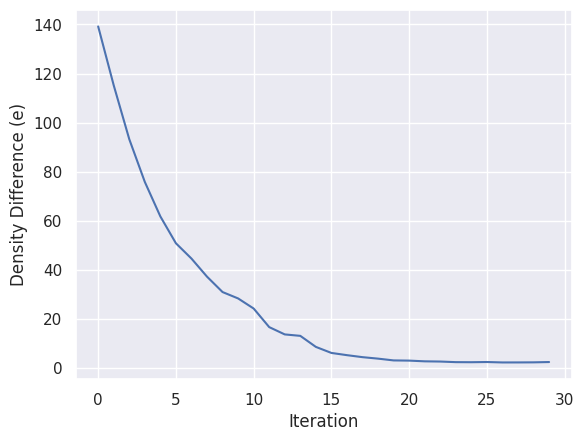

In [18]:
# Loss
data = Train["difference"]
print(Train["difference"])
sns.set()
sns.lineplot(x=np.arange(len(data)), y=data)
plt.xlabel("Iteration")
plt.ylabel("Density Difference (e)")
plt.show()

In [ ]:
# Partition
for i in range(Result["N_atom"].shape[0]):
    visualize((Result["partition"]==i).reshape(Result["shape"]).astype(int), 0.1)

In [ ]:
# Save Result
np.savez(Molecule["name"], **Result)

In [ ]:
# Save Train
np.savez(Molecule["name"]+"_train", **Train)

In [2]:
Result = np.load('Acyclovir.npz')

In [3]:
Train = np.load("Acyclovir_train.npz")